# Tarea semanal 7 : Filtrado digital lineal de ECG

## Consignas

Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

* Ruido causado por el movimiento de los electrodos (Alta frecuencia).
* Ruido muscular (Alta frecuencia).
* Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).
  
Se pide:

a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.

d)  Evalúe el rendimiento de los filtros que haya diseñado:
* Verifique que filtra las señales interferentes.
* Verifique que es inocuo en las zonas donde no hay interferentes.

## Introduccion

A partir del problema planteado, loque buscamos es poder limpiar la señal del ECG eliminando los ruidos que sabemos que tenemos dentro de los datos. Y para lograr este cometido es que vamos a utilizar las tecnicas de filtrado lineal que hemos estado viendo en clase. Rapidamente, podemos categorizarlas en 2 grupos:

* Filtros IIR ( Infinite Impulse Response ); Estos filtros tienen recursividad lo que genera que su la respuesta al impulso sea infinita. Es decir, que cuando al sistema ingresa una delta, la salida es infinita y no termina una vez pasa el valor del delta. Para llegar a esto partimos de 2 funciones matematicas que son:
  * Las familias de Maxima Planicidad, que dentro de ellas esta el caso particular del Butterworh
  * Aproximantes de Chevushev

Ahora, a partir de esto es que diseñamos los filtros IIR dentro de nuestro entorno. Mas particularmente con la funcion iir design. A la cual le pasamos la plantilla del filtro a diseñar y esta nos devuelve los parametros para poder implementarlo. La gran ventaja de estos filtros, es que no requieren de una gran cantidad de coeficientes para funcionar pero la recursividad puede generar problemas numericos. Ya que, un error crece muy rapidamente y si no tenemos un sistema lo suficientemente robusto no se puede implementar correctamente. En general, un IIR mayor a orden 9 no se puede implementar directamente. Por lo que, para mitigar todo esto se suele recomendar el uso de la metodología de: " Second Order Sections ". Esto nos permite desarmar el filtro en bloques de orden 2 para minimizar la propagación de errores evitando los problemas antes mencionados.

* Filtros FIR ( Finite Impulse Response ); A diferencia de los IIR estos no tienen una respuesta infinita al colocarles un delta, sino que, decae en un tiempo finito. Eso es una gran ventaja en terminos numericos ya que no trae los problemas de los IIR pero en consecuencia necesitamos ordenes mucho mayores para obtener los mismos resultados. Por ejemplo, con un IIR de orden 8 se podria conseguir un buen Bandpass para el ECG cuando en cambio, con un fir requeriamos de 2500 coeficientes para lograrlo. Con esto en mente, los filtros que vamos a utilizar son:
    * Ventanas
    * Cuadrados Minimos
    * Parks-McClellan

Ya habiendo introducido los conceptos de los filtros que vamos a utilizar, pasamos a diseñar los filtros según lo requerido en las consignas.

## Plantilla de filtro ECG

Todos los filtros antes mencionados parten de la misma base, de una plantilla. En la misma colocamos los requerimientos que vamos a pedirle al filtro de podamos eliminar los ruidos de la señal. 

Hablando de ello, sabemos que el ruido que tenemos es: 
* Ruido causado por el movimiento de los electrodos (Alta frecuencia).
* Ruido muscular (Alta frecuencia).
* Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

Por lo que, en resumen, tenemos tanto ruido de baja como alta frecuencia. De la TS5 sabemos que el el BW en donde tenemos el 98% de toda la densidad espectral de potencia del ECG esta al rededor de los 35 hz. Por lo que, la parte derecha de nuestra banda de paso deberá estar al rededor de dicho valor. 

Adicionalmente, sabemos que tenemos ruido de baja frecuencia inducido por la respiración. Por lo que, podemos estimar que todo lo que esta por debajo de 1 hz, es este ruido. Entonces, la parte izquierda de nuestra banda de paso va a ser dicha frencia. 

Finalmente, la pantilla del filtro quedaría:

fs = 1000
nyq_frec = fs/2
ripple = 1              # dB
atenuacion = 40         # dB

ws1 = 0.5        # Hz
wp1 = 1         # Hz
wp2 = 30        # Hz
ws2 = 35        # Hz

En donde tenemos definidas a las frecuencias de la banda de stop y de paso. Adicionalmente, vemos que tenemos la frecuencia a la que estamos sampleando ( 1000 hz ). El ripple, que es la maxima atenuacion que vamos a permitir en la banda de paso y la atenuacion que es como minimo, lo que quiero que se atenue le señal en las bandas de stop. 

Con todo esto en mente, hacemos un codigo donde aplicamos todo lo anterior:


## Filtrado de ECG con filtros IIR y FIR

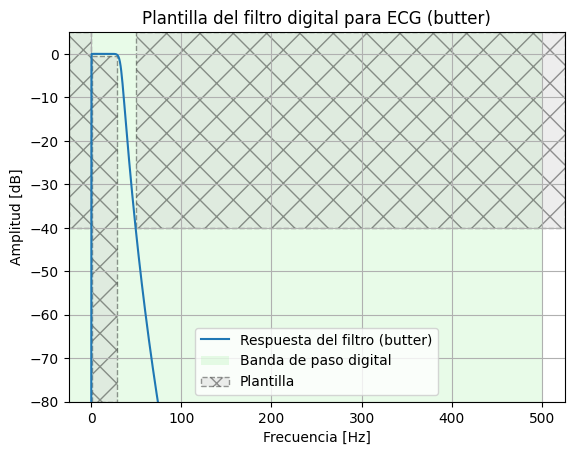

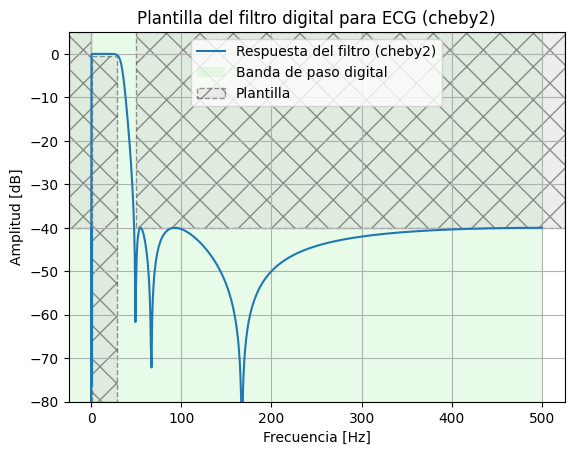

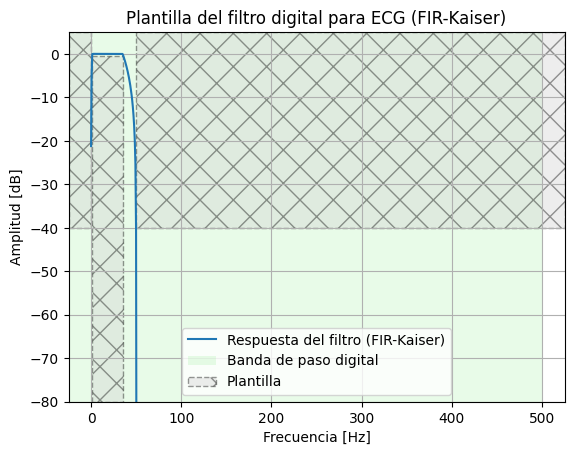

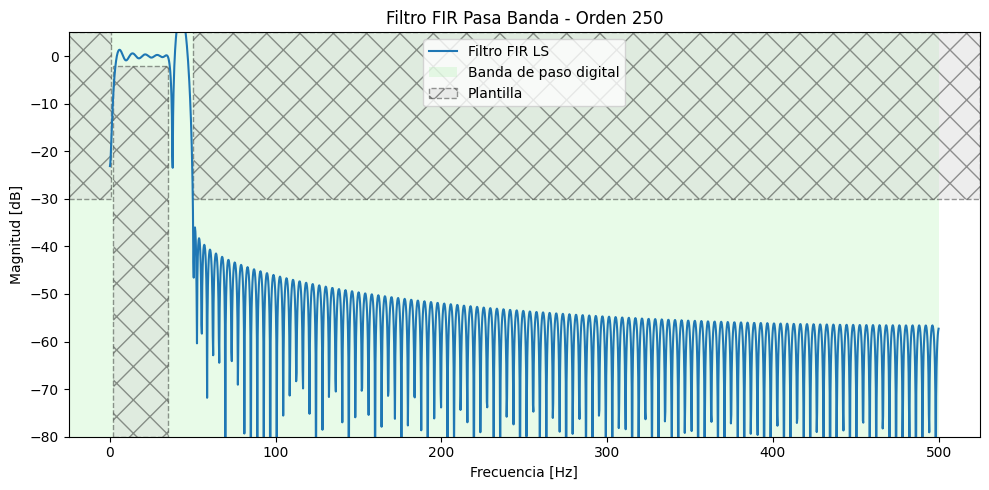

In [7]:
#%% Importado de módulos

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.interpolate import CubicSpline
from pytc2.sistemas_lineales import bodePlot, plot_plantilla
from scipy.signal import sosfreqz



def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

#%% Lectura del ECG

fs = 1000  # Hz

mat_struct = sio.loadmat('./ecg.mat')
ecg_one_lead = np.squeeze(mat_struct['ecg_lead']).astype(float)

# Normalización
ecg_one_lead = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)

# Tiempo total
t_ecg = np.arange(len(ecg_one_lead)) / fs

nyq_frec = fs / 2

#%% Diseño de filtro IIR - Plantilla de filtro - Butter

aprox_name = 'butter'
# aprox_name = 'cheby1'
# aprox_name = 'cheby2'
# aprox_name = 'ellip'

# Parametros de la plantilla del filtro 


fpass = np.array([0.5, 30])      # Banda de paso
fstop = np.array([0.2, 50])      # Banda de detención
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuación en banda de detención (dB)

#%% Diseño de filtro con iirdesing

Butter_iir = sig.iirdesign(
    wp=     fpass,
    ws=     fstop,
    gpass=  ripple,
    gstop=  attenuation,
    ftype=  aprox_name,
    output='sos',
    fs=     fs
)

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sosfreqz(Butter_iir, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro ({aprox_name})')
plt.title(f'Plantilla del filtro digital para ECG ({aprox_name})')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

fpass = np.array([0.5, 29]) 

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs
)

plt.legend()
plt.show()

#%% Diseño de filtro IIR - Plantilla de filtro - Cheby

# aprox_name = 'butter'
# aprox_name = 'cheby1'
aprox_name = 'cheby2'
# aprox_name = 'ellip'

# Parametros de la plantilla del filtro 

fpass = np.array([0.5, 30])      # Banda de paso
fstop = np.array([0.2, 50])      # Banda de detención
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuación en banda de detención (dB)

#%% Diseño de filtro con iirdesing

Cheby_iir = sig.iirdesign(
    wp=     fpass,
    ws=     fstop,
    gpass=  ripple,
    gstop=  attenuation,
    ftype=  aprox_name,
    output='sos',
    fs=     fs
)

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sosfreqz(Cheby_iir, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro ({aprox_name})')
plt.title(f'Plantilla del filtro digital para ECG ({aprox_name})')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

fpass = np.array([0.5, 29]) 

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs
)

plt.legend()
plt.show()

#%% Diseño de filtros con FIR - Ventanas



# Parametros de la plantilla del filtro 

fpass = np.array([1.3, 35])      # Banda de paso
fstop = np.array([0.1, 50])      # Banda de detención
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuación en banda de detención (dB)

#%% Diseño de filtro con firwin2

cant_coef = 5001    # cantidad de coeficientes (orden + 1), ideal impar

nyq = fs / 2        # frecuencia de Nyquist

# Definimos los puntos de frecuencia y ganancia
# En Hz: queremos un filtro pasabanda entre 1 y 35 Hz

freq_hz = [0.0, 0.1, 1, 35.0, 50.0, nyq]   # en Hz
gain =    [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]     # ganancia deseada en cada punto

# Normalizar las frecuencias
freq_norm = [f / nyq for f in freq_hz]

# Diseñar el filtro con firwin2
Windows_fir = sig.firwin2(
    numtaps=        cant_coef,
    freq=           freq_norm,
    gain=           gain,
    window=         ('kaiser', 10) )

aprox_name = 'FIR-Kaiser' 

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sig.freqz(Windows_fir, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro ({aprox_name})')
plt.title(f'Plantilla del filtro digital para ECG ({aprox_name})')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs
)

plt.legend()
plt.show()

#%% Diseño de FIR con cuadrados minimos

from pytc2.filtros_digitales import fir_design_ls

# Parámetros

fstop = np.array([0.5, 50])    # Banda de detención
fpass = np.array([2, 35])      # Banda de paso
ripple = 2                     # dB (banda de paso)
attenuation = 30              # dB (banda de detención)

# Frecuencias normalizadas (por Nyquist = fs/2)
fn = fs / 2
Be = [
    0.0, fstop[0]/fn,           # detención baja
    fpass[0]/fn, fpass[1]/fn,   # paso
    fstop[1]/fn, 1.0            # detención alta
]

# Respuesta deseada en cada banda
D = [0, 0, 1, 1, 0, 0]

# Peso relativo (convertido de dB aproximado)
W = [10**(attenuation/20), 1, 10**(attenuation/20)]  # enfatiza la banda de paso

# Estimamos orden (puedes refinar esto)
N = 250  # orden del filtro (ajustable)

# Diseño del filtro
lsq_fir = fir_design_ls(order=N, band_edges=Be, desired=D, weight=W, filter_type='m', grid_density=16)

# Evaluamos FFT
fft_sz = 4096
H = np.fft.fft(lsq_fir, fft_sz)
frecuencias = np.linspace(0, fn, fft_sz//2)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(frecuencias, 20*np.log10(np.abs(H[:fft_sz//2]) + 1e-8), label='Filtro FIR LS')
plt.title("Respuesta en Frecuencia del Filtro FIR Pasabanda")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.ylim([-80, 5])
plt.grid(True)
plt.legend()
plt.tight_layout()


# Plantilla
plot_plantilla(filter_type='bandpass',
               fpass=fpass,
               ripple=ripple,
               fstop=fstop,
               attenuation=attenuation,
               fs=fs)

plt.title(f"Filtro FIR Pasa Banda - Orden {N}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


## Observaciones del diseño

En los graficos que se ven arriba podemos ver la plantilla con los requerimientos y el respuntado de cada uno de los filtros. A grandes rasgos, se pudo diseñar filtros que satisfagan dichos requerimientos con algunas salvedades.

Primero, para los filtros IIR, debido a que sencillez en el diseño se pudo general facilmente un filtro que alcance los requerimientos de la plantilla sin mayores dificultades tanto al usuar Butter como Cheby. En cambio, al momento del diseño de los filtros FIR pude ver el grado de dificultad extra que conlleva su diseño, ya que, se requirió de varias iteraciones y modificaciones en el filtro para poder satisfacer la plantilla. hasta, en algunos casos tuve que " relajar " los requerimientos de la misma para que el filtro pudiese cumplir con lo requerido. Esto sobre todo se hizo evidente en el metodo de cuadrados minimos. En donde a pesar de tener muchisimos coeficientes, me resultó mucho mas dificil de diseñar que usando el metodo de ventanas pero se puede ver rapidamente que pasamos de 5001 coeficientes a 250. 

Con todo esto, ahora pasamos a aplicar los filtros a la señal del ECG y ver su funcionamiento. Para ello, vamos a hacer un zoom a la señal donde podamos ver la eliminacion tanto de comportamiento de baja como alta frecuencia:


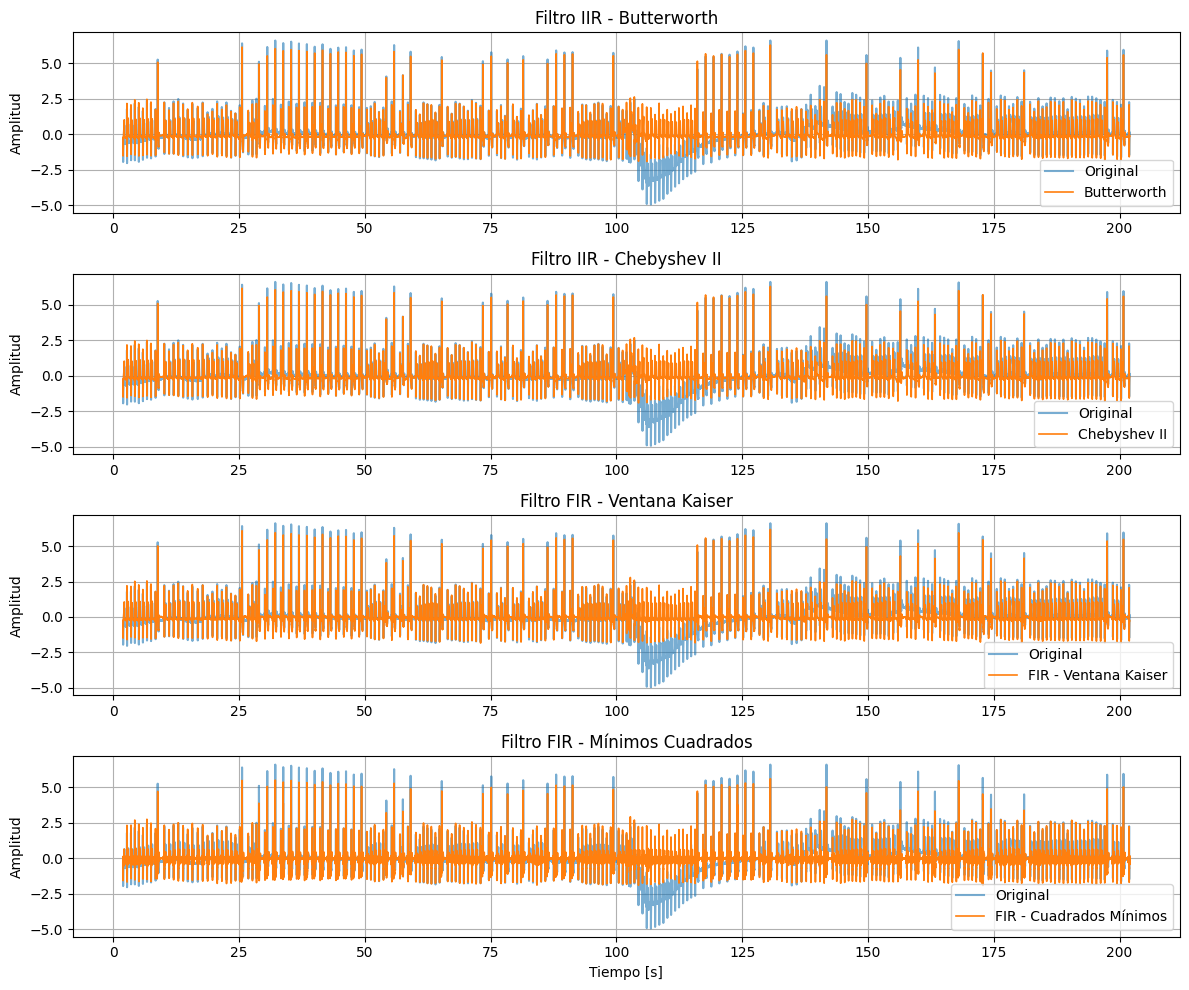

In [8]:
#%% Aplicación de los 4 filtros y graficado

# Aplicación de los filtros
ecg_butter = sig.sosfiltfilt(Butter_iir, ecg_one_lead)
ecg_cheby  = sig.sosfiltfilt(Cheby_iir, ecg_one_lead)
ecg_winfir = sig.filtfilt(Windows_fir, [1], ecg_one_lead)
ecg_lsqfir = sig.filtfilt(lsq_fir, [1], ecg_one_lead)

# Seleccionamos una ventana de tiempo para visualizar
seg_inicio = 2  # segundo inicial
seg_dur = 200     # duración de la ventana
idx_inicio = int(seg_inicio * fs)
idx_fin = int((seg_inicio + seg_dur) * fs)

t_zoom = t_ecg[idx_inicio:idx_fin]
ecg_orig_zoom = ecg_one_lead[idx_inicio:idx_fin]

# Subplots
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t_zoom, ecg_orig_zoom, label='Original', alpha=0.6)
plt.plot(t_zoom, ecg_butter[idx_inicio:idx_fin], label='Butterworth', linewidth=1.2)
plt.title('Filtro IIR - Butterworth')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t_zoom, ecg_orig_zoom, label='Original', alpha=0.6)
plt.plot(t_zoom, ecg_cheby[idx_inicio:idx_fin], label='Chebyshev II', linewidth=1.2)
plt.title('Filtro IIR - Chebyshev II')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t_zoom, ecg_orig_zoom, label='Original', alpha=0.6)
plt.plot(t_zoom, ecg_winfir[idx_inicio:idx_fin], label='FIR - Ventana Kaiser', linewidth=1.2)
plt.title('Filtro FIR - Ventana Kaiser')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t_zoom, ecg_orig_zoom, label='Original', alpha=0.6)
plt.plot(t_zoom, ecg_lsqfir[idx_inicio:idx_fin], label='FIR - Cuadrados Mínimos', linewidth=1.2)
plt.title('Filtro FIR - Mínimos Cuadrados')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Podemos ver que en lineas generales, el filtrado de la señal por los 4 metodos cumple con lo esperado sacando los ruidos de baja frecuencia que se pueden ver entre el tiempo 100 y 125. Pero con este nivel de zoon no podemos apreciar los pequeños detalles. Por lo que, vamos a tratar de analizar las ROI ( Regions of Interest ) de la señal en donde podamos tener una mejor visualizacion del funcionamiento. 

Pero, a grandez rasgos los 4 filtros se comportan de la misma manera. Esto implica que el diseño a partir de la plantilla se realizó correctamente. 

### Regiones de interes ( ROI )

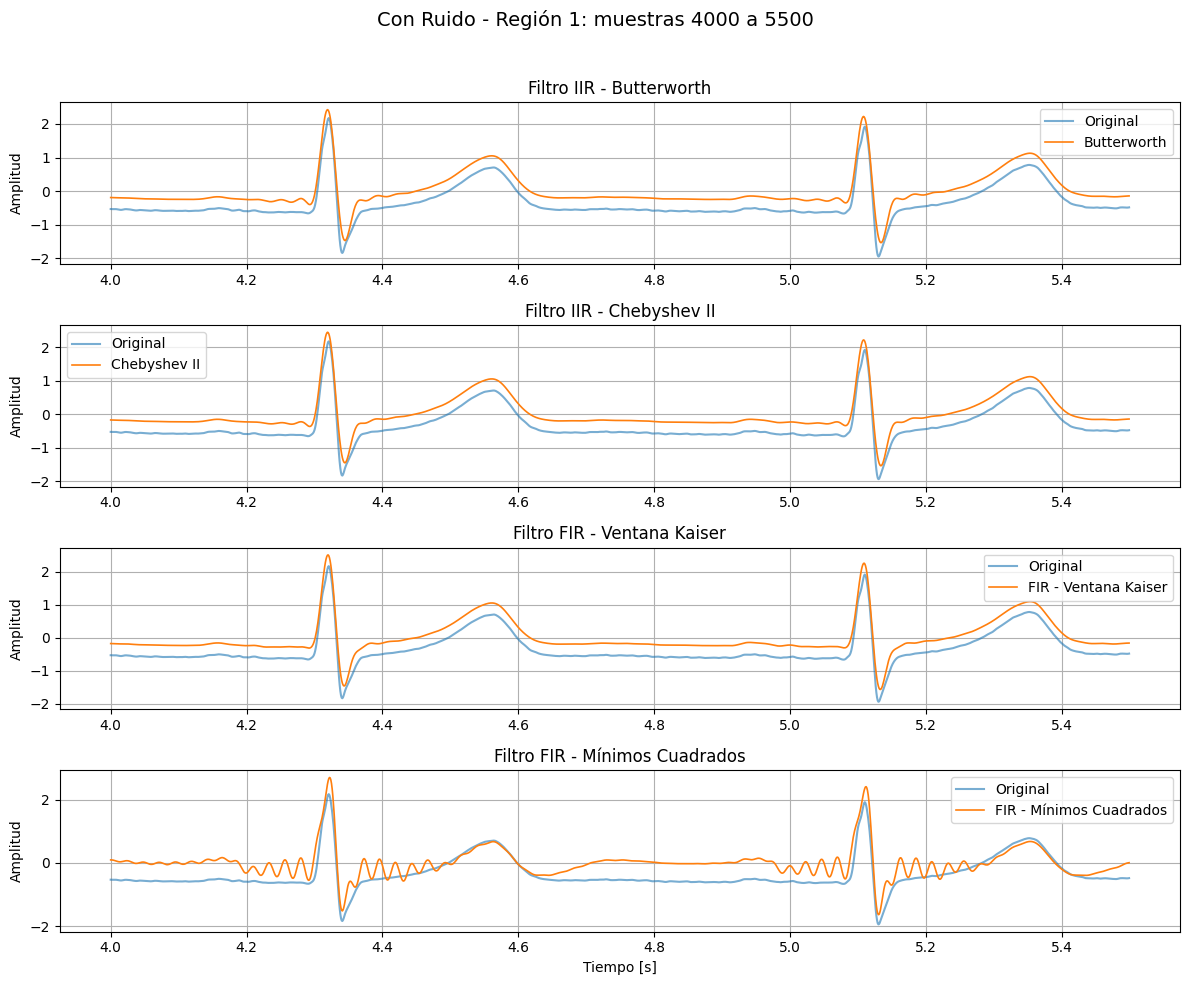

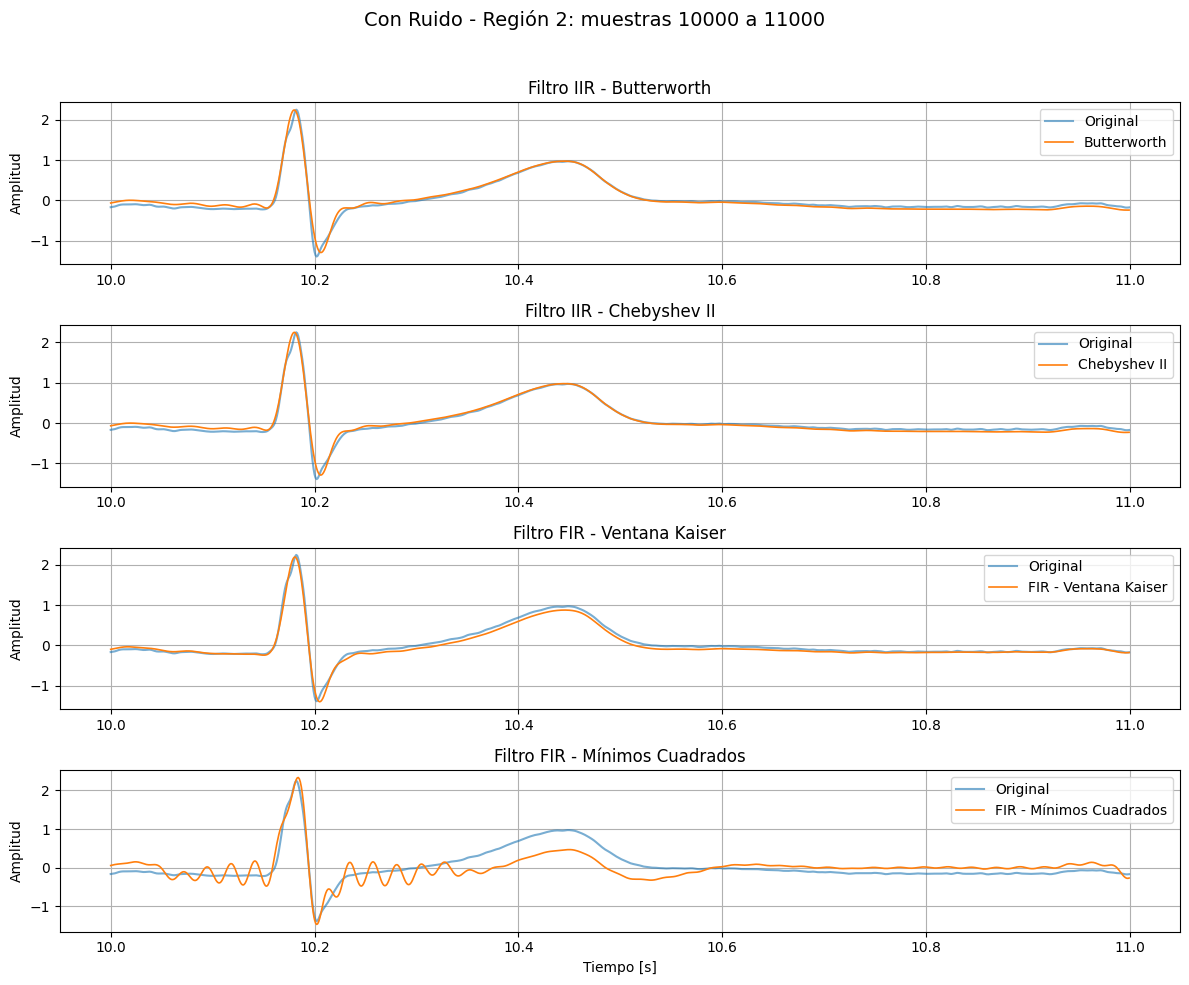

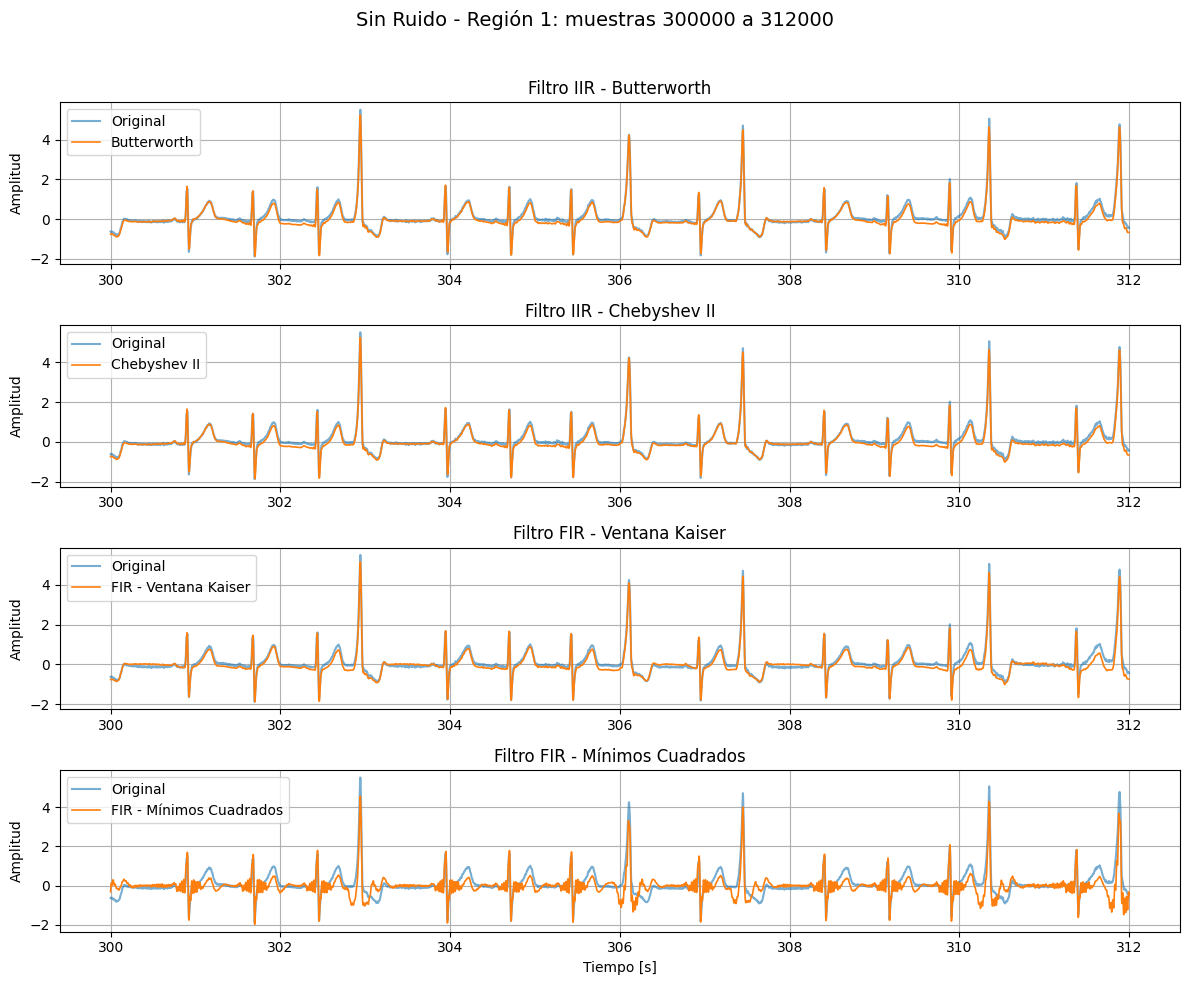

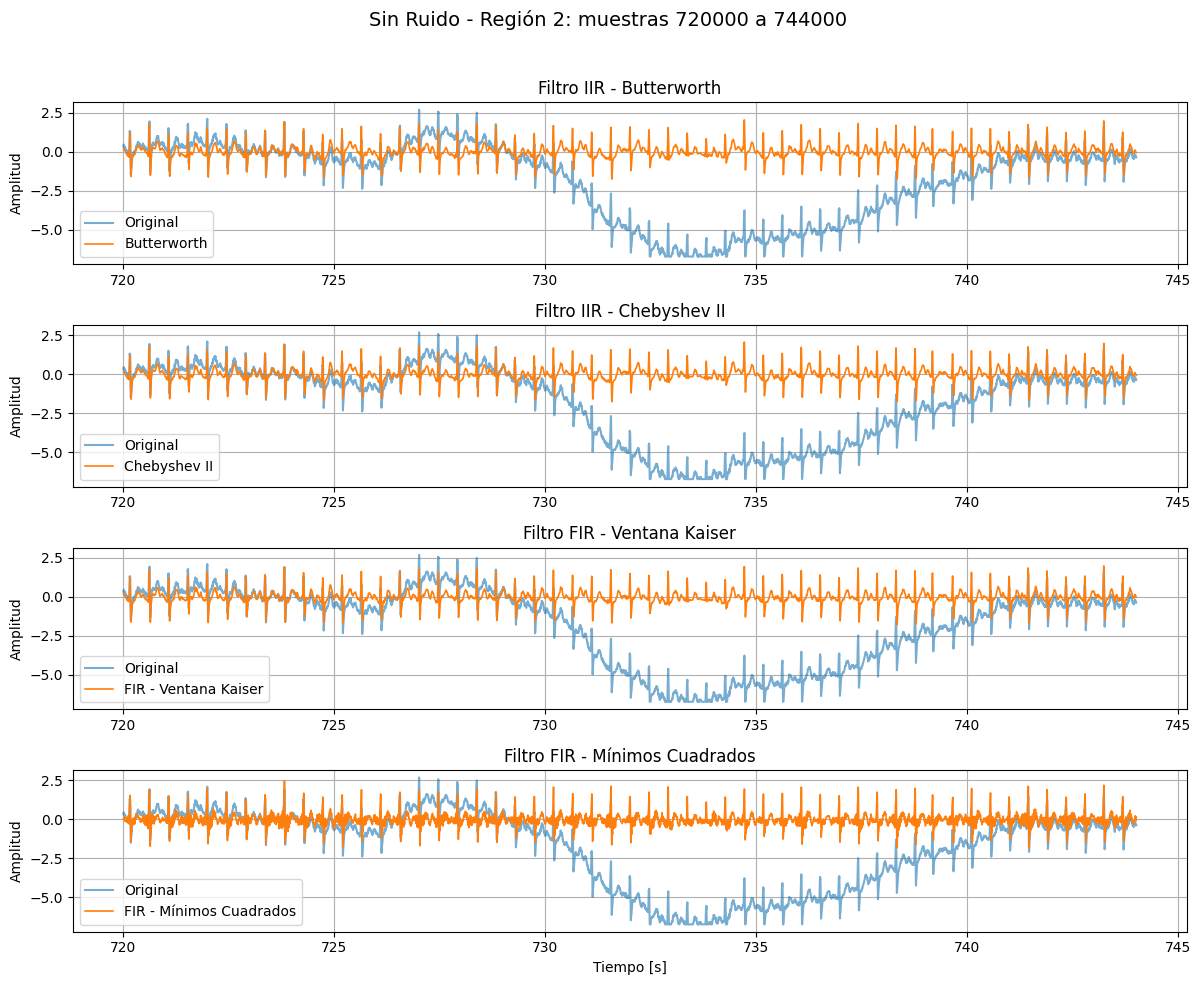

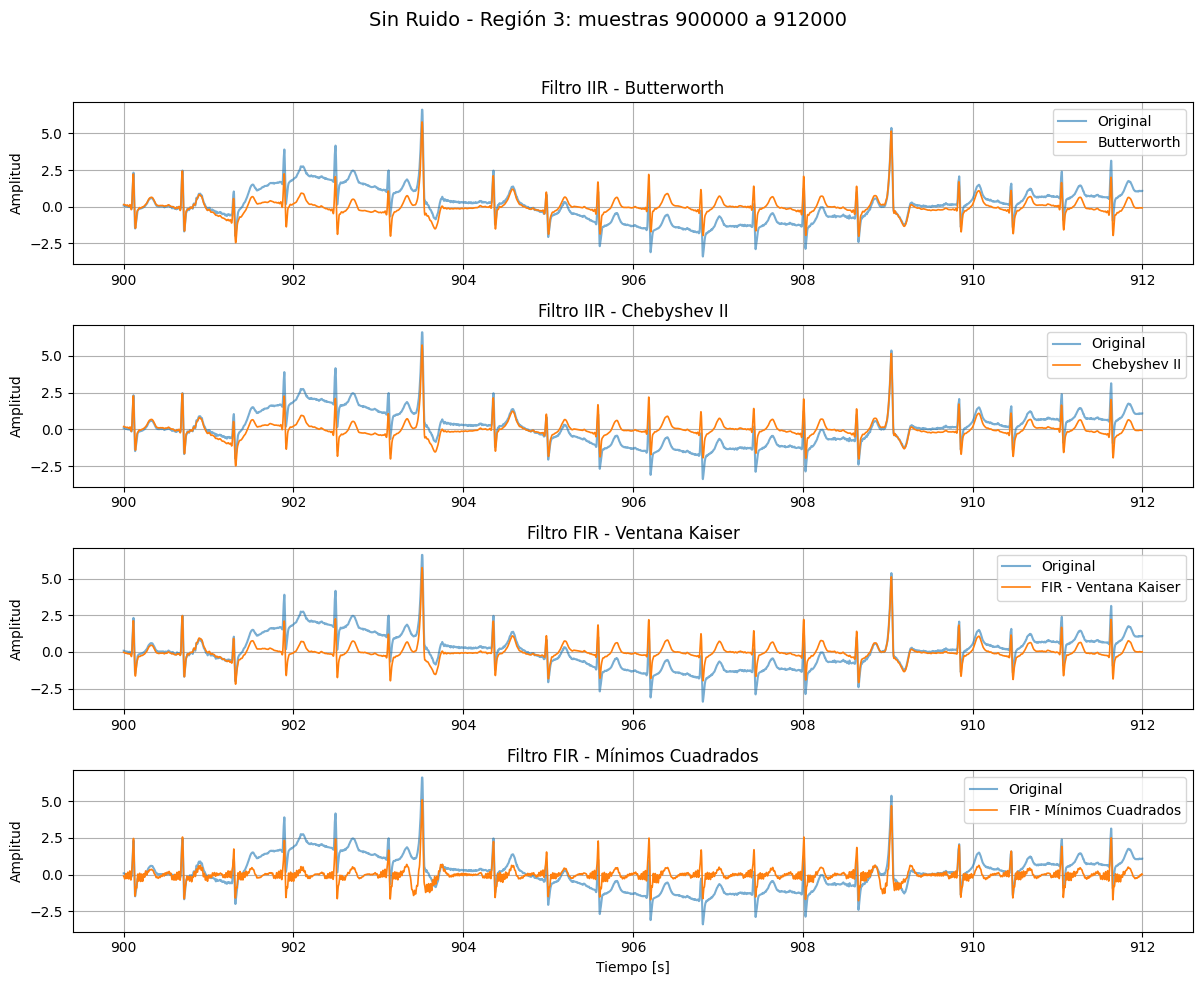

In [9]:
#%% Analizamos regiones de interes

cant_muestras = len(ecg_one_lead)

# Regiones de interés con ruido (en muestras)
regs_ruido = (
    [4000, 5500],
    [10_000, 11_000],
)

# Regiones sin ruido (en minutos convertidos a muestras)
regs_sin_ruido = (
    np.array([5, 5.2]) * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

# Juntamos todo en una lista con etiquetas
regiones = [("Con Ruido", regs_ruido), ("Sin Ruido", regs_sin_ruido)]

for tipo_region, lista_regiones in regiones:
    for i, reg in enumerate(lista_regiones):
        # Convertimos a enteros por seguridad
        reg = np.array(reg, dtype=int)
        # Limitamos a rango válido
        zoom_region = np.arange(np.max([0, reg[0]]), np.min([cant_muestras, reg[1]]), dtype='uint')

        # Tiempo correspondiente a la región
        t_zoom = t_ecg[zoom_region]

        # Subplots
        plt.figure(figsize=(12, 10))
        plt.suptitle(f'{tipo_region} - Región {i+1}: muestras {reg[0]} a {reg[1]}', fontsize=14)

        plt.subplot(4, 1, 1)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_butter[zoom_region], label='Butterworth', linewidth=1.2)
        plt.title('Filtro IIR - Butterworth')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_cheby[zoom_region], label='Chebyshev II', linewidth=1.2)
        plt.title('Filtro IIR - Chebyshev II')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_winfir[zoom_region], label='FIR - Ventana Kaiser', linewidth=1.2)
        plt.title('Filtro FIR - Ventana Kaiser')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_lsqfir[zoom_region], label='FIR - Mínimos Cuadrados', linewidth=1.2)
        plt.title('Filtro FIR - Mínimos Cuadrados')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## Analisis de lo obtenido 

Ahora con una mejor vision de las regiones de interes podemos ver mas en profundidad el rendimiento de cada uno de los filtros que se han diseñado. 

### 1. Rendimiento en regiones con ruido

En condiciones donde la señal ECG está contaminada por ruido, especialmente en altas frecuencias, los diferentes filtros presentan comportamientos particulares que impactan la calidad de la señal filtrada de distintas formas.

El **filtro Butterworth**, de tipo IIR, se caracteriza por una respuesta suave y sin ondulaciones abruptas, lo que lo convierte en una opción adecuada para eliminar ruido de alta frecuencia sin introducir artefactos notorios. Su respuesta en frecuencia no es la más selectiva, pero precisamente por eso evita oscilaciones o distorsiones bruscas. Uno de los inconvenientes típicos de los filtros IIR es el desfase que pueden introducir, pero al aplicar un filtrado hacia adelante y hacia atrás con `sosfiltfilt`, este retardo es efectivamente eliminado, preservando así la morfología de la señal.

El **filtro Chebyshev Tipo II**, también IIR, mejora la selectividad respecto al Butterworth al ofrecer una mayor pendiente de atenuación en la banda de transición. Esto le permite eliminar con más eficacia el ruido fuera de la banda de paso. Sin embargo, esta ganancia en selectividad viene con el riesgo de introducir distorsiones en los bordes de la señal, especialmente si se aplica un filtrado unidireccional. Al igual que con el Butterworth, el uso de `sosfiltfilt` mitiga estos efectos de fase y mejora significativamente la calidad de la señal filtrada.

En contraste, el **filtro FIR con ventana de Kaiser** ofrece una alternativa con fase lineal, lo que significa que no introduce ningún tipo de distorsión temporal en la señal. Esto es especialmente importante en señales ECG, donde la precisión en la localización de eventos como las ondas P, QRS y T es fundamental. La ventana de Kaiser permite un diseño flexible, con buen compromiso entre atenuación y ancho de banda de transición. Este tipo de filtro ofrece una excelente supresión de ruido de alta frecuencia sin alterar la forma de la señal. Sin embargo, su implementación requiere un número considerable de coeficientes, lo que se traduce en una mayor demanda computacional.

Finalmente, el **filtro FIR diseñado por mínimos cuadrados** permite un control más preciso sobre las bandas de paso y de detención. También mantiene fase lineal, por lo que la morfología de la señal se conserva completamente. Comparado con la ventana de Kaiser, este enfoque puede presentar una ligera desventaja en cuanto a la atenuación en los bordes de las bandas, lo que puede dejar pasar algo más de ruido si no se ajusta adecuadamente el diseño. Algo que en esta ocasion esta sucediendo, ya que vemos que se agregan artefactos a la señal alterando su morfología original. Mas particulamente, se pueden observar ondulaciones u oscilaciones agregadas. 

---

### 2. Rendimiento en regiones limpias (sin ruido aparente)

En regiones del ECG que ya están libres de ruido o con señales limpias, todos los filtros aplicados conservan la forma general de la señal.

Los filtros IIR, como Butterworth y Chebyshev II, aunque eficaces contra el ruido, tienden a suavizar ligeramente las transiciones abruptas, como las del complejo QRS. Esto se debe a que sus respuestas en frecuencia no son perfectamente planas en la banda de paso, lo cual puede reducir la nitidez de eventos rápidos. Esta suavización puede ser aceptable en ciertas aplicaciones, pero en contextos donde se requiere alta precisión temporal, puede representar una limitación.

Por otro lado, los filtros FIR, tanto el de ventana Kaiser como el de mínimos cuadrados, preservan con mayor fidelidad la morfología exacta de la señal, incluyendo la localización precisa de eventos eléctricos rápidos. Esto se debe a su fase lineal, que asegura que todas las frecuencias de la banda de paso se retrasen por igual, manteniendo las relaciones temporales entre las distintas ondas del ECG intactas. Este comportamiento es especialmente valioso en análisis detallados de ritmos cardíacos o en el cálculo de intervalos diagnósticos.

El filtro FIR con ventana de Kaiser resulta particularmente eficaz cuando la plantilla de diseño ha sido ajustada para el espectro del ECG. Su respuesta es limpia y suprimirá el ruido sin alterar la señal útil. En cambio, el diseño por mínimos cuadrados ofrece mayor control sobre la forma de la respuesta, permitiendo adaptar mejor el filtro a casos específicos, aunque esa flexibilidad puede venir a costa de una menor precisión en la definición de las transiciones y en este caso generando las ondulaciones antes mencionadas. 



### Conclusiones

Si bien fue posible diseñar filtros que cumplen razonablemente con la plantilla establecida para el procesamiento de señales ECG, el filtro **FIR por mínimos cuadrados** mostró limitaciones importantes. En particular, su comportamiento en la banda de paso presenta un rizado excesivo (ripple), y parte de su respuesta penetra en la banda de rechazo definida por la plantilla. Esto parece ser el origen de las ondulaciones observadas al hacer zoom en la señal filtrada. A pesar de múltiples intentos por ajustar coeficientes y relajar los requisitos de diseño, no se logró una mejora significativa en su rendimiento. Aun así, este filtro consigue atenuar de forma moderada los ruidos de baja frecuencia (como los generados por el movimiento respiratorio) y los de alta frecuencia, aunque con menor eficacia que otros diseños.

Por otro lado, los filtros que mostraron mejor desempeño global fueron el **FIR con ventana** y el **IIR tipo Chebyshev II**. Ambos lograron una muy buena supresión tanto del ruido de baja frecuencia como del de alta frecuencia, manteniendo al mismo tiempo la morfología característica del ECG. Una ventaja clave observada en estos filtros es que no generan artefactos ante la presencia de eventos abruptos, como los latidos ectópicos, que se asemejan a impulsos tipo delta de Dirac. Es decir, la respuesta al impulso del filtro no se manifiesta de forma invasiva en estas situaciones, lo cual es fundamental para preservar la fidelidad clínica de la señal.

Si se tuviera que elegir una única opción, el **filtro FIR con ventana** sería preferible en escenarios donde se disponga de tiempo y recursos para optimizar su diseño, ya que ofrece una respuesta muy plana en la banda de paso y garantiza una distorsión mínima de la señal original, gracias a su fase lineal. No obstante, en contextos donde se requiera una solución rápida y eficaz, el **filtro IIR Chebyshev II** constituye una excelente alternativa. Su implementación es sencilla y su rendimiento, especialmente cuando se aplica con técnicas como `sosfiltfilt`, se acerca bastante al del FIR, manteniendo un buen equilibrio entre eficiencia computacional y calidad de filtrado.


---

## Bonus

💎 Proponga algún tipo de señal, ya sea de la TS anterior u otra que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.

Vamos a utilizar lo visto en la TS5, en la cual usamos una señal de respiracion de un estudio del MIT. Pongo l

---

## Análisis de Señal Respiratoria a partir de Datos Reales

Para aplicar los métodos desarrollados anteriormente en señales biológicas reales, se utilizó una base de datos pública del MIT correspondiente a un estudio de sueño realizado en 2005: la **MIT-BIH Polysomnographic Database**. Esta base incluye registros polisomnográficos completos de pacientes, conteniendo señales como ECG, respiración, EEG, EOG, EMG, entre otras.

A partir de esta base, se seleccionó un conjunto de datos de un paciente y se extrajo exclusivamente la señal de respiración, generando un archivo `.csv` que contiene únicamente esa variable. Esto permitió trabajar directamente con la señal respiratoria y analizar su comportamiento utilizando las técnicas de procesamiento previamente desarrolladas.

---

### Digitalización de las señales

Según la documentación oficial de la base de datos, las señales fueron registradas y digitalizadas con las siguientes características:

| Parámetro              | Valor                                |
|------------------------|--------------------------------------|
| Resolución del ADC     | 12 bits                              |
| Rango de tensión       | ±5 mV (valor típico, puede variar)   |
| Frecuencia de muestreo | 125 Hz o 250 Hz (según el canal)     |
| Formato original       | Archivos `.dat` (binario) y `.hea` (cabecera), en formato WFDB |

En particular, las señales respiratorias (respiración torácica, abdominal y flujo respiratorio) fueron registradas típicamente a una **frecuencia de muestreo de 125 Hz**, por lo que esta frecuencia (`Fs = 125`) será la utilizada en el procesamiento posterior.

---

### Conversión a formato CSV

Para trabajar más fácilmente con la señal respiratoria en Python, se convirtió el registro original al formato `.csv` utilizando la librería `wfdb` de **PhysioNet**. El procedimiento consistió en:

1. Leer el registro con:  
   `wfdb.rdsamp('slp01a')`

2. Convertirlo a un `DataFrame` de Pandas.

3. Exportarlo a CSV con:  
   `df.to_csv('slp01a_respiration.csv')`

Este procedimiento conserva los valores de las muestras tal como fueron digitalizadas, sin realizar conversión a unidades físicas como litros o mmHg. Por tanto, el análisis se realiza directamente sobre los valores relativos de la señal, que mantienen la morfología y las oscilaciones típicas de la respiración.

---

Finalmente, en la TS5 vimos que el BW de esta señal de respiracion era de aproximadamente 0.366 hz. Por lo que, vamos a filtrar dicha señal con un lowpass y así eliminar todo el ruido de alta frecuencia que tiene la señal digitalizada. 


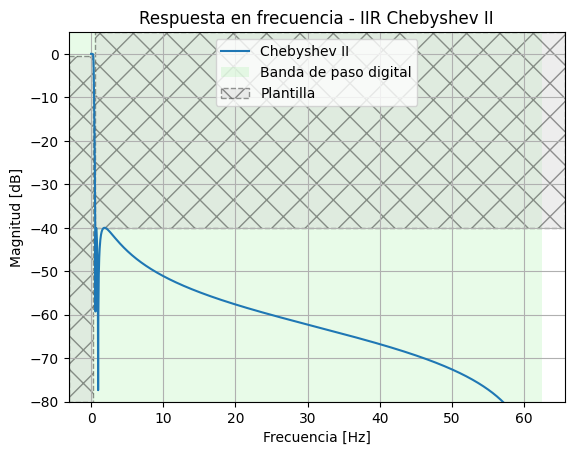

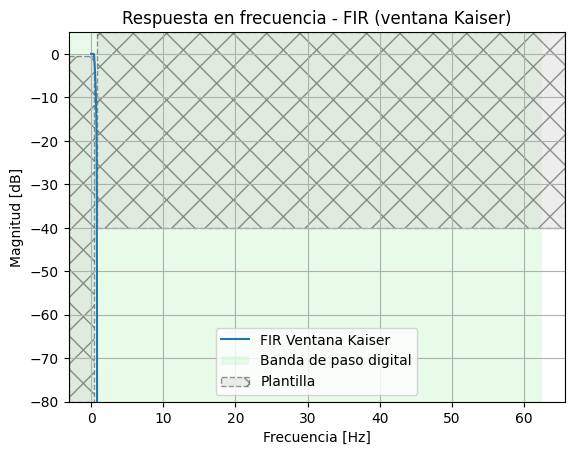

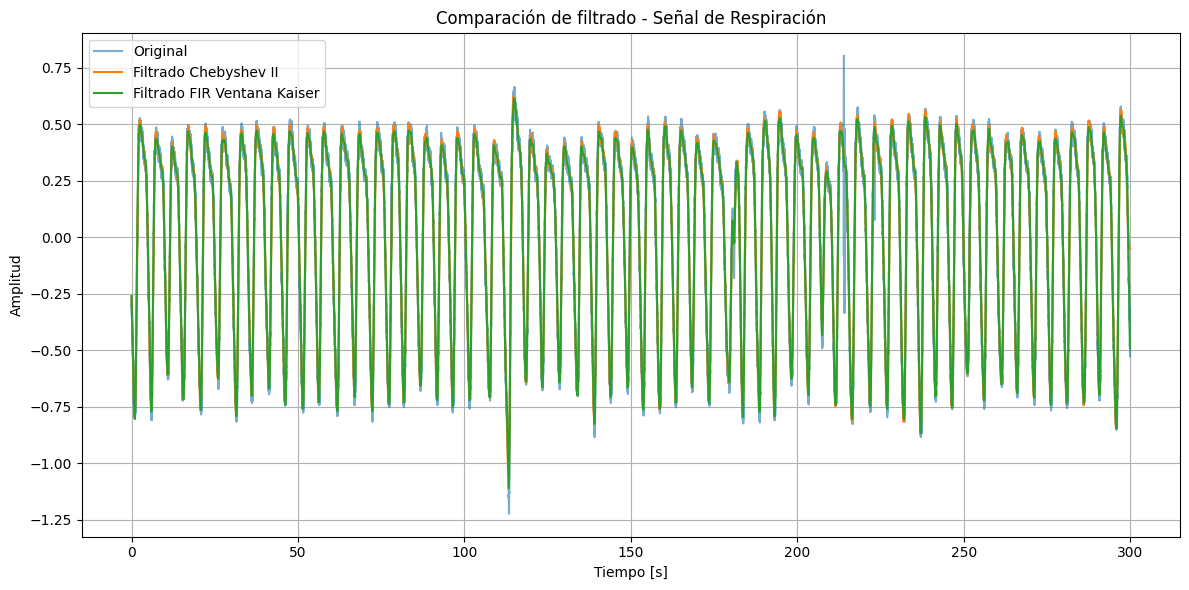

In [10]:

#%% Importacion de modulos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy.signal import sosfreqz
from pytc2.sistemas_lineales import plot_plantilla

#%% Cargar archivo CSV con datos de respiración
csv_path = "slp01a_respiration.csv"
df = pd.read_csv(csv_path)

#%% Seleccionar primeros 300 segundos
df_300 = df[df["Time [s]"] <= 300]
time = df_300["Time [s]"]
resp_signal = df_300.iloc[:, 1].values  # Asumimos que la señal de respiración está en la segunda columna

#%% Definir parámetros
fs = 125
nyq = fs / 2

#%% Filtro IIR Chebyshev II
fpass = 0.3     # Hz
fstop = 0.6     # Hz
ripple = 0.5    # dB
attenuation = 40  # dB

cheby2_iir = sig.iirdesign(
    wp=fpass,
    ws=fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='cheby2',
    output='sos',
    fs=fs
)

# Evaluar respuesta en frecuencia
w, h = sosfreqz(cheby2_iir, worN=2048, fs=fs)

# Graficar respuesta
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h) + 1e-10), label='Chebyshev II')
plt.title("Respuesta en frecuencia - IIR Chebyshev II")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.ylim([-80, 5])
plt.grid(True)
plot_plantilla('lowpass', fpass=fpass, fstop=fstop, ripple=ripple, attenuation=attenuation, fs=fs)
plt.legend()
plt.show()

#%% Filtro FIR con ventanas (Kaiser)
cant_coef = 8001  # número de coeficientes (orden + 1)
freq_hz = [0.0, 0.4, 0.8, nyq]
gain =    [1.0, 1.0, 0.0, 0.0]

fpass = 0.4     # Hz
fstop = 0.85     # Hz

freq_norm = [f / nyq for f in freq_hz]

fir_window = sig.firwin2(
    numtaps=cant_coef,
    freq=freq_norm,
    gain=gain,
    window=('kaiser', 10)
)

# Evaluar respuesta
w_fir, h_fir = sig.freqz(fir_window, worN=2048, fs=fs)

# Graficar respuesta
plt.figure()
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir) + 1e-10), label='FIR Ventana Kaiser')
plt.title("Respuesta en frecuencia - FIR (ventana Kaiser)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.ylim([-80, 5])
plt.grid(True)
plot_plantilla('lowpass', fpass=fpass, fstop=fstop, ripple=ripple, attenuation=attenuation, fs=fs)
plt.legend()
plt.show()

#%% Aplicar filtros a la señal de respiración
resp_cheby = sig.sosfiltfilt(cheby2_iir, resp_signal)
resp_fir = sig.filtfilt(fir_window, [1], resp_signal)

#%% Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(time, resp_signal, label='Original', alpha=0.6)
plt.plot(time, resp_cheby, label='Filtrado Chebyshev II', linewidth=1.5)
plt.plot(time, resp_fir, label='Filtrado FIR Ventana Kaiser', linewidth=1.5)
plt.title('Comparación de filtrado - Señal de Respiración')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Al igual que antes, hagamos un zoom en regiones de interes para analizar mejor el comportamiento de los filtros

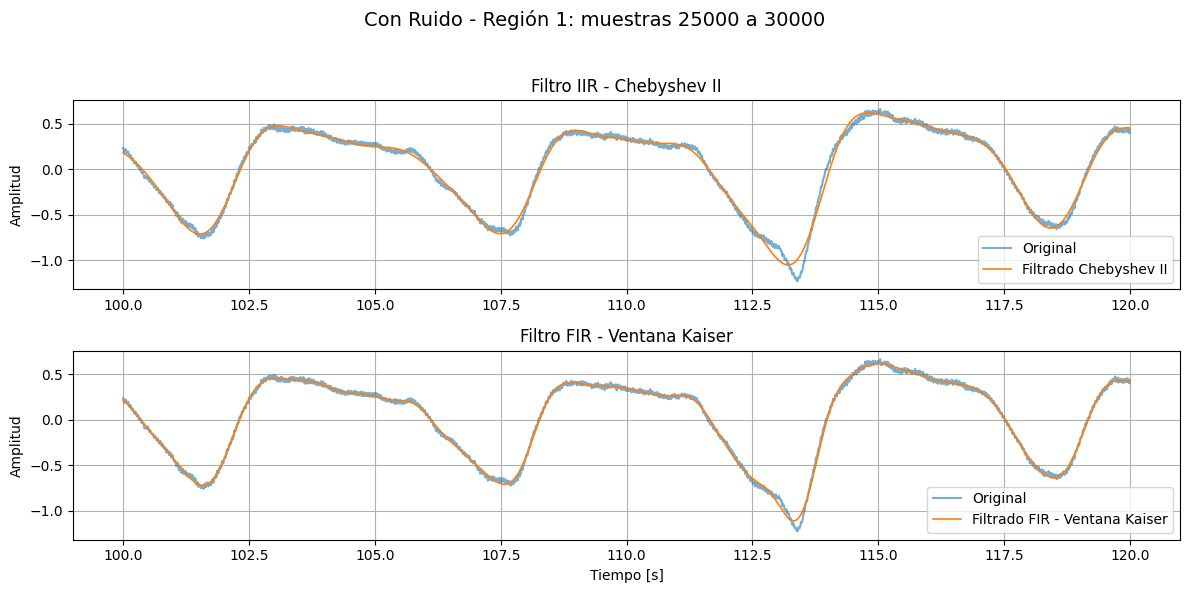

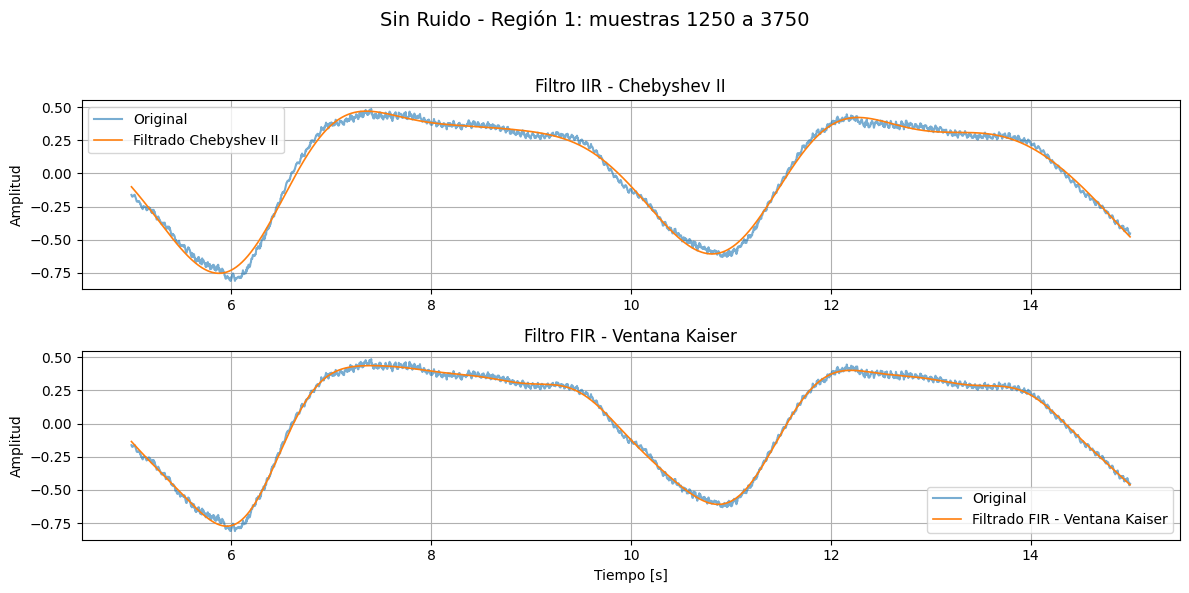

In [13]:
#%% Definir regiones de interés para señal de respiración
cant_muestras = len(resp_signal)

# Regiones (en segundos) convertidas a muestras
regs_ruido = (
    np.array([200, 240]) * fs,  # Con ruido
)
regs_sin_ruido = (
    np.array([10, 30]) * fs,    # Sin ruido
)

# Juntamos todo en una lista con etiquetas
regiones = [("Con Ruido", regs_ruido), ("Sin Ruido", regs_sin_ruido)]

#%% Gráficos por regiones
for tipo_region, lista_regiones in regiones:
    for i, reg in enumerate(lista_regiones):
        reg = np.array(reg, dtype=int)
        zoom_region = np.arange(np.max([0, reg[0]]), np.min([cant_muestras, reg[1]]), dtype='uint')

        # Tiempo correspondiente a la región
        t_zoom = time[zoom_region]

        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{tipo_region} - Región {i+1}: muestras {reg[0]} a {reg[1]}', fontsize=14)

        plt.subplot(2, 1, 1)
        plt.plot(t_zoom, resp_signal[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, resp_cheby[zoom_region], label='Filtrado Chebyshev II', linewidth=1.2)
        plt.title('Filtro IIR - Chebyshev II')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(t_zoom, resp_signal[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, resp_fir[zoom_region], label='Filtrado FIR - Ventana Kaiser', linewidth=1.2)
        plt.title('Filtro FIR - Ventana Kaiser')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

### Análisis de los resultados

En este caso, la señal de respiración presenta un comportamiento claramente pasabajo, con un ancho de banda acotado aproximadamente entre 0 y 0.366 Hz. Esta característica facilita el diseño de filtros, ya que el contenido relevante se concentra en bajas frecuencias y el objetivo principal es atenuar el ruido de alta frecuencia.

Se analizaron dos regiones: una correspondiente a los primeros segundos de la señal, donde se espera una señal más limpia, y otra con presencia evidente de ruido. En ambas, los filtros diseñados (Chebyshev II e FIR con ventana Kaiser) se comportaron adecuadamente, cumpliendo con los requisitos definidos por la plantilla de diseño.

Los resultados muestran que los filtros lograron eliminar ondulaciones de alta frecuencia sin alterar significativamente la morfología general de la señal. Esto es especialmente evidente en regiones donde hay variaciones abruptas —por ejemplo, alrededor del segundo 113 en la región ruidosa— donde el filtro reduce eficazmente el ruido sin afectar la estructura de la señal subyacente.

En resumen, ambos filtros cumplen con su objetivo de forma efectiva. No obstante, cabe destacar que, en el caso del filtro FIR, fue necesario aumentar considerablemente el número de coeficientes y relajar levemente los requisitos de la plantilla para lograr un desempeño aceptable dentro de los parámetros deseados.

